In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix


In [2]:
path_to_query_adata = "/mnt/sata2/Analysis_Alex_2/perturb4_no_baysor/final_object_corrected.h5ad"
query_adata = sc.read(path_to_query_adata)

In [3]:
import sys
sys.path.insert(0, '/home/amonell/piloting/scvi-tools/src')
print("Added to path:", sys.path[0])

import scvi.external.resolvi as RESOLVI
import scvi
print("Importing from:", scvi.external.resolvi.__file__)

Added to path: /home/amonell/piloting/scvi-tools/src
Importing from: /home/amonell/piloting/scvi-tools/src/scvi/external/resolvi/__init__.py


In [4]:
#sc.pp.subsample(query_adata, fraction=0.1)

In [5]:
query_adata

AnnData object with n_obs × n_vars = 810225 × 480
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'total_transcripts', 'nuclear_transcripts', 'cytoplasmic_transcripts', 'nuclear_transcript_percentage', 'topic', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'Class', 'reference_crypt_villi', 'villi_number', 'peyers', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'crypt_villi_axis', 'epithelial_distance', 'epithelial_distance_clipped', 'epithelial_distance_transformed', 'guide_rnas', 'cell_types', 'cluster_cellcharter', 'epithelial_distance_scaled'
    uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_color

In [6]:
RESOLVI.RESOLVI.setup_anndata(query_adata, labels_key="cell_types", layer="raw", batch_key="batch", perturbation_key='guide_rnas', control_perturbation='Other cells')

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [7]:
supervised_resolvi = RESOLVI.RESOLVI(
    query_adata, semisupervised=True
)

In [8]:


priors = supervised_resolvi.compute_dataset_dependent_priors()
print(priors)


{'background_ratio': 0.00067531277, 'median_distance': 372.9849853515625, 'mean_log_counts': 5.433722, 'std_log_counts': 0.8109416}


In [9]:
supervised_resolvi.module.guide.downsample_counts_mean = float(
    supervised_resolvi.module.guide.downsample_counts_mean
)
supervised_resolvi.module.guide.downsample_counts_std = float(
    supervised_resolvi.module.guide.downsample_counts_std
)
supervised_resolvi.train(
    max_epochs=100,
    check_val_every_n_epoch=1,
    lr=3e-4
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


In [10]:
celltype = 'CD8 T Cells'

In [11]:
cell_indices = np.where(query_adata.obs['guide_rnas'] == 'sgCd19')[0]
effects_cells = supervised_resolvi.get_perturbation_effects(
    indices=cell_indices
)

In [12]:
df = pd.DataFrame(list(zip(query_adata.obs['guide_rnas'].values, query_adata.obsm['_scvi_extra_categorical_covs']['guide_rnas'].values)), columns = ['celltype', 'perturb_number'])
celltype_to_perturb_number = dict(zip(df['perturb_number'], df['celltype']))

celltype_to_perturb_number = {f'perturbation_{k}': v for k, v in celltype_to_perturb_number.items()}


In [ ]:
check with not just sgCD19 cells to see if the effects are correct per perturbation

In [13]:
effects_cells.index = effects_cells.index.map(celltype_to_perturb_number)

In [14]:
corrected_expression = supervised_resolvi.get_normalized_expression(
    adata=query_adata
)


In [15]:
query_adata.layers['resolvi_expression'] = corrected_expression

In [16]:
effects_cells[['Perturbation_0', 'Perturbation_1', 'Perturbation_2', 'Perturbation_3', 'Perturbation_4', 'Perturbation_5', 'Perturbation_6', 'Perturbation_7', 'Perturbation_8', 'Perturbation_9','Perturbation_10', 'Perturbation_11', 'Perturbation_12']]

,Perturbation_0,Perturbation_1,Perturbation_2,Perturbation_3,Perturbation_4,Perturbation_5,Perturbation_6,Perturbation_7,Perturbation_8,Perturbation_9,Perturbation_10,Perturbation_11,Perturbation_12
sgCcl3,2.874806,19.160364,6.388443,0.201119,-20.670746,-1.166933,-10.835580,-0.110471,-0.855805,-0.081244,0.195878,4.542780,4.370708
sgCcl5,-2.236362,4.684650,0.901016,5.537687,-18.235567,15.476541,-3.338196,-1.207629,-0.852490,1.324303,1.539592,-0.559420,0.844948
sgCcr2,-8.085830,3.590285,-4.617732,9.379992,-13.378963,-5.323315,-5.965637,10.375556,8.623631,0.960834,4.208341,2.480992,8.849915
sgCcr5,-4.301214,-1.411390,-3.548807,6.601032,-10.128555,4.446296,9.700940,1.333399,1.941900,5.353590,0.219391,0.909097,0.145740
sgCcr7,1.418920,9.808092,4.993503,13.004617,-11.708674,-5.258995,-6.457880,2.204088,7.653031,-0.052484,10.748857,18.918304,7.671401
sgCcr9,-4.540980,-0.999130,-4.552577,7.332010,-9.036146,-5.345237,-2.156088,2.365047,19.045683,8.418612,4.802162,2.700347,8.941113
sgCd19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sgCx3cl1,3.856467,4.460322,-1.669933,19.732450,-17.083132,-3.259833,-7.573131,1.811448,3.136096,2.496780,7.567008,4.655779,8.687515
sgCxcl10,12.904445,1.285914,-0.242254,5.656240,-13.949637,0.756664,-6.161464,-2.454207,1.513980,2.090132,0.023631,0.535436,3.966376
sgCxcr3,-8.313396,-0.511764,5.806157,10.417801,-14.076895,0.294410,-4.428475,-0.360913,9.233188,2.346184,19.557667,6.064520,14.815597


In [29]:
effects_cells[['Cxcr3', 'Ccr5', 'Ccl5', 'Ccr7', 'Cxcr4', 'Ccl3', 'Cxcr6', 'Xcl1']]

,Cxcr3,Ccr5,Ccl5,Ccr7,Cxcr4,Ccl3,Cxcr6,Xcl1
sgCcl3,0.069972,-0.052302,0.060548,-1.787424,-0.838122,-0.933494,-0.004318,-0.601272
sgCcl5,0.094507,0.373469,-1.568632,0.691247,0.023551,-0.017396,0.035179,-1.787266
sgCcr2,-0.051643,0.085297,0.023550,0.558069,-0.134709,-0.485313,-0.496485,-1.131798
sgCcr5,0.058405,-0.486401,0.042077,0.571914,0.552598,-0.446033,0.039880,-0.654149
sgCcr7,-0.290892,-0.052353,0.121326,-3.353213,-0.157476,-1.014067,-0.380376,0.431453
sgCcr9,-0.095416,0.016516,0.074185,-3.811601,0.312368,-0.475164,-0.182171,-0.725917
sgCd19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sgCx3cl1,-0.103356,0.005020,-0.108732,-0.142765,-0.357919,-0.595575,-0.036647,-1.340909
sgCxcl10,-0.173034,0.122085,0.249191,-3.288608,-1.369615,-0.461474,-0.003570,-1.163594
sgCxcr3,-0.262572,-0.019385,0.202802,-7.403136,-0.376156,0.615694,-0.174944,0.277345


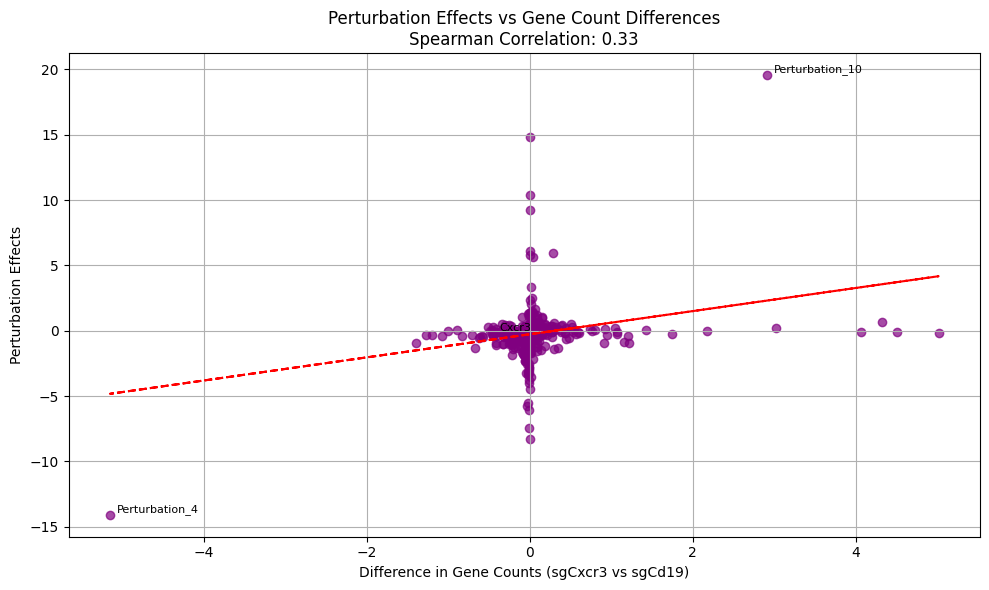

In [19]:

from scipy.stats import spearmanr
import numpy as np

perturbation_effects = effects_cells.loc['sgCxcr3'].values
# Calculate the difference in gene counts between the two batches
batch1_counts = query_adata[query_adata.obs['guide_rnas'] == 'sgCxcr3'].X.mean(axis=0)
batch2_counts = query_adata[query_adata.obs['guide_rnas'] == 'sgCd19'].X.mean(axis=0)
gene_count_diff = batch1_counts - batch2_counts

# Filter perturbation effects where values are less than 0.05
valid_indices = np.abs(perturbation_effects) >= 0
gene_count_diff_filtered = gene_count_diff[valid_indices]
perturbation_effects_filtered = perturbation_effects[valid_indices]

# Get gene names for annotation
gene_names = query_adata.var.index.values if hasattr(query_adata.var, "index") else np.arange(len(perturbation_effects))
gene_names_filtered = gene_names[valid_indices]

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(gene_count_diff_filtered, perturbation_effects_filtered)

# Plot the perturbation effects against the gene count differences
plt.figure(figsize=(10, 6))
plt.scatter(gene_count_diff_filtered, perturbation_effects_filtered, color='purple', alpha=0.7)

# Annotate each point with the gene name (optionally, only annotate top N by abs effect for clarity)
# Annotate only the gene 'Cxcr3' and the gene at index corresponding to 'Perturbation_4' (if present)
# Annotate 'Cxcr3' if it is in gene_names_filtered
if 'Cxcr3' in gene_names_filtered:
    idx_cxcr3 = np.where(gene_names_filtered == 'Cxcr3')[0][0]
    plt.annotate('Cxcr3',
                 (gene_count_diff_filtered[idx_cxcr3], perturbation_effects_filtered[idx_cxcr3]),
                 textcoords="offset points", xytext=(5,2), ha='left', fontsize=8, color='black')

# Annotate 'Perturbation_4' if it is in gene_names_filtered
if 'Perturbation_4' in gene_names_filtered:
    idx_pert4 = np.where(gene_names_filtered == 'Perturbation_4')[0][0]
    plt.annotate('Perturbation_4',
                 (gene_count_diff_filtered[idx_pert4], perturbation_effects_filtered[idx_pert4]),
                 textcoords="offset points", xytext=(5,2), ha='left', fontsize=8, color='black')
    
# Annotate 'Perturbation_10' if it is in gene_names_filtered
if 'Perturbation_10' in gene_names_filtered:
    idx_pert4 = np.where(gene_names_filtered == 'Perturbation_10')[0][0]
    plt.annotate('Perturbation_10',
                 (gene_count_diff_filtered[idx_pert4], perturbation_effects_filtered[idx_pert4]),
                 textcoords="offset points", xytext=(5,2), ha='left', fontsize=8, color='black')

# Add line of best fit
m, b = np.polyfit(gene_count_diff_filtered, perturbation_effects_filtered, 1)
plt.plot(gene_count_diff_filtered, m * gene_count_diff_filtered + b, color='red', linestyle='--')

plt.xlabel('Difference in Gene Counts (sgCxcr3 vs sgCd19)')
plt.ylabel('Perturbation Effects')
plt.title(f'Perturbation Effects vs Gene Count Differences\nSpearman Correlation: {spearman_corr:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

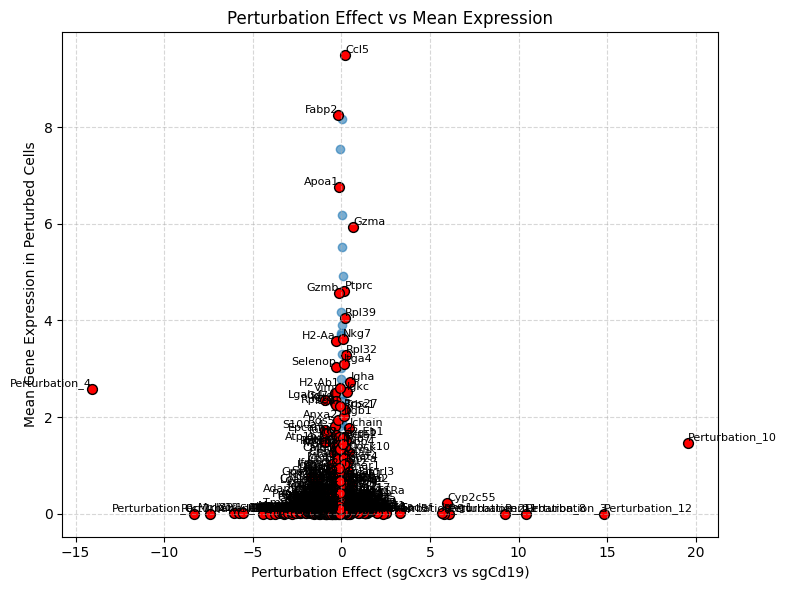

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Compute perturbation effects and mean expression ---
effects = effects_cells.loc['sgCxcr3'].values

# mean expression in sgCxcr3 and sgCd19 separately
mean_Cxcr3 = query_adata[query_adata.obs['guide_rnas']=='sgCxcr3'].X.mean(axis=0)
mean_Cd19  = query_adata[query_adata.obs['guide_rnas']=='sgCd19'].X.mean(axis=0)

# total mean across both perturbed sets
mean_expr = (mean_Cxcr3 + mean_Cd19) / 2

# filter out non‐finite values
mask = np.isfinite(effects) & np.isfinite(mean_expr)

# build a DataFrame
df = pd.DataFrame({
    'gene': query_adata.var.index.values if hasattr(query_adata.var, "index") else np.arange(len(effects)),
    'effect': effects[mask],
    'mean_expr': mean_expr[mask]
})

# --- 2) Select top N by absolute effect for annotation ---
N = 400
topN = df.iloc[np.argsort(np.abs(df['effect']))[::-1][:N]]

# always include your genes of special interest
for g in ['Cxcr3','Perturbation_4','Perturbation_10']:
    if g in df['gene'].values:
        topN = pd.concat([topN, df[df['gene']==g]])
topN = topN.drop_duplicates('gene')

# --- 3) Plot volcano‐style scatter: effect vs mean expression ---
plt.figure(figsize=(8,6))
plt.scatter(df['effect'], df['mean_expr'], alpha=0.6)

# highlight the top hits
plt.scatter(topN['effect'], topN['mean_expr'], color='red', edgecolor='k', s=50)

# annotate
for _, row in topN.iterrows():
    plt.text(row['effect'], row['mean_expr'], row['gene'],
             fontsize=8,
             ha='right' if row['effect']<0 else 'left',
             va='bottom')

plt.xlabel('Perturbation Effect (sgCxcr3 vs sgCd19)')
plt.ylabel('Mean Gene Expression in Perturbed Cells')
plt.title('Perturbation Effect vs Mean Expression')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [10]:


# 4. Get uncertainty estimates (multiple samples)
effects_with_uncertainty = supervised_resolvi.get_perturbation_effects(
    n_samples=100,
    return_mean=False  # Returns (n_samples, n_perturbations, n_genes)
)

# Calculate mean and standard deviation
effects_mean = effects_with_uncertainty.mean(axis=0)
effects_std = effects_with_uncertainty.std(axis=0)

# 5. Return as numpy array instead of DataFrame
effects_numpy = supervised_resolvi.get_perturbation_effects(
    return_numpy=True
)


perturbation_1 - Top upregulated genes:
Olfm4      0.160932
S100a4     0.146479
Cd74       0.140134
Il17a      0.136326
Lgr5       0.132411
Jchain     0.131299
Meg3       0.128033
Neurog3    0.125850
Mzb1       0.125348
Scn7a      0.124500
Name: perturbation_1, dtype: float32

perturbation_1 - Top downregulated genes:
Muc13    -0.125823
mt-Co1   -0.117608
Rbp2     -0.101208
Fabp2    -0.093622
Apoa1    -0.074589
Slc9a3   -0.073016
Ifngr1   -0.072394
Il18     -0.068574
Pcsk5    -0.060879
Ifngr2   -0.060798
Name: perturbation_1, dtype: float32

perturbation_2 - Top upregulated genes:
Upp1      0.180055
Cd74      0.155298
H2-Aa     0.086877
Itga6     0.075242
Ccl20     0.074872
Cd8b1     0.061757
Irf8      0.057358
H2-Eb1    0.054356
Il1a      0.053360
Atp1b1    0.047624
Name: perturbation_2, dtype: float32

perturbation_2 - Top downregulated genes:
Tyrobp   -0.097767
Muc13    -0.093395
C1qb     -0.084836
Csf1r    -0.083398
C1qa     -0.076835
Il2rg    -0.075518
Pecam1   -0.072680
Acta2   

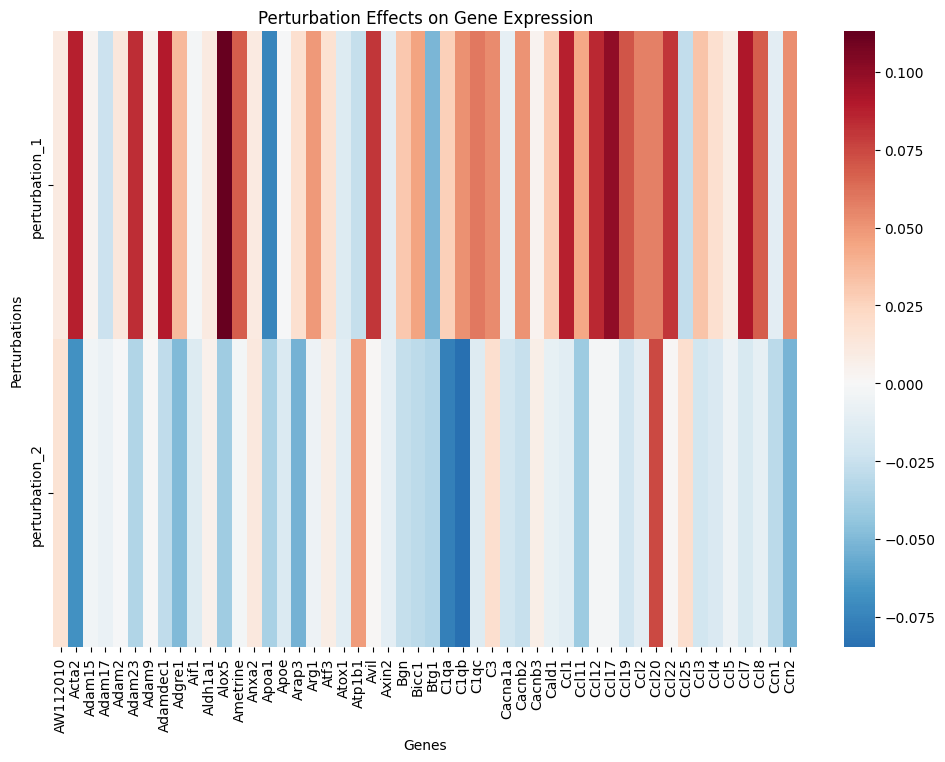

In [9]:
# Extract effects
effects_df = supervised_resolvi.get_perturbation_effects()

# Find genes most affected by each perturbation
for perturbation in effects_df.index:
    # Get top 10 upregulated genes
    top_up = effects_df.loc[perturbation].nlargest(10)
    print(f"\n{perturbation} - Top upregulated genes:")
    print(top_up)
    
    # Get top 10 downregulated genes  
    top_down = effects_df.loc[perturbation].nsmallest(10)
    print(f"\n{perturbation} - Top downregulated genes:")
    print(top_down)

# Visualize effects
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of perturbation effects
plt.figure(figsize=(12, 8))
sns.heatmap(effects_df.iloc[:, :50], cmap='RdBu_r', center=0)  # First 50 genes
plt.title('Perturbation Effects on Gene Expression')
plt.xlabel('Genes')
plt.ylabel('Perturbations')
plt.show()
